In [1]:
%load_ext jupyter_black
%matplotlib inline

import os
# Set cuda device to use
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# do not prealocate memory when using jax
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

backend = "pyro"
platform = "cpu"  # "gpu"

if backend == "pyro":
    import torch

    tensor = torch
    torch.set_default_dtype(torch.float32)
    if platform == "gpu":
        device = torch.device(f"cuda:{torch.cuda.current_device()}")
        torch.set_default_device(device)

    torch.manual_seed(111)

else:
    import jax.numpy as jnp
    import jax.random as jr
    from numpyro import set_platform

    set_platform(platform)

    key = jr.PRNGKey(111)
    tensor = jnp

A brief tutorial for simulating behaviour in a multi armed bandit task and using simulated response to invert the model and infer model parameters for individual agents/subjects

In [3]:
import numpy as np
from local import MABTask, UCBAgent
from pybefit.agents import transform

if backend == "pyro":
    from pybefit.inference import PyroGuide as Guide
    from pybefit.inference import PyroModel as Model
    from pyro.infer import Predictive
    from pybefit.inference.pyro.likelihoods import befit_likelihood as likelihood
    from pybefit.inference.methods import (
        default_dict_pyro_svi,
        format_posterior_samples,
        get_log_evidence_per_subject,
    )

    default_dict_svi = default_dict_pyro_svi

else:
    import jax.random as jr
    from pybefit.inference import NumpyroGuide as Guide
    from pybefit.inference import NumpyroModel as Model
    from numpyro.infer import Predictive
    from pybefit.inference.numpyro.likelihoods import befit_likelihood as likelihood
    from pybefit.inference.methods import (
        default_dict_numpyro_svi,
        format_posterior_samples,
        get_log_evidence_per_subject,
    )

    default_dict_svi = default_dict_numpyro_svi

from pybefit.inference.methods import default_dict_nuts
from pybefit.inference import Normal as Prior
from pybefit.inference import NormalPosterior as Posterior

# uncomment to use a hierarchical prior over model parameters
# from pybefit.inference import RegularisedHorseshoe as priors
# from pybefit.inference import RegularisedHorseshoePosterior as Posterior

from pybefit.inference import run_nuts, run_svi

/home/dimitrije/.conda/envs/befit/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We start by first generating a time sequence of possible choice outcomes for the task and pack this inside the "MABTask" class.

In [5]:
blocks = 20
trials = 10
num_arms = 3
num_agents = 1000

# create task environment
probs = np.random.dirichlet(np.ones(num_arms), size=(num_agents,))
outcomes = np.random.binomial(
    1, probs, size=(blocks, trials, num_agents, num_arms)
).astype(np.float32)

if backend == "pyro":
    outcomes = tensor.tensor(outcomes)
else:
    outcomes = tensor.ones(1) * outcomes

print(outcomes.dtype, outcomes.shape)

mab_task = (
    MABTask(outcomes, backend="torch")
    if backend == "pyro"
    else MABTask(outcomes, backend="jax")
)

# create agent to recover number of parameters
if backend == "pyro":
    ucb_agent = UCBAgent(
        runs=num_agents,
        blocks=blocks,
        trials=trials,
        num_arms=num_arms,
        backend="torch",
    )
else:
    ucb_agent = UCBAgent(
        runs=num_agents, blocks=blocks, trials=trials, num_arms=num_arms, backend="jax"
    )

num_params = ucb_agent.num_params

# set task and agent option dictionaries
opts_task = {
    "task": mab_task,
    "blocks": blocks,
    "trials": trials,
    "num_agents": num_agents,
    "seed": 123,
}

# set kwargs for transform which are passed to the agent constractor
if backend == "pyro":
    opts_transform = {
        "blocks": blocks,
        "trials": trials,
        "num_arms": num_arms,
        "backend": "torch",
    }
else:
    opts_transform = {
        "blocks": blocks,
        "trials": trials,
        "num_arms": num_arms,
        "backend": "jax",
    }


# set options for prior, transform and likelihood
opts_model = {"prior": {}, "transform": opts_transform, "likelihood": opts_task}

# define a transform for mapping unconstrained parameters 'z' to the corresponding agent class
transform_ucb = lambda z, **kwargs: transform(z, UCBAgent, **kwargs)

prior = Prior(num_params, num_agents, init_scale=0.1, backend=backend)
gen_model = Model(prior, transform_ucb, likelihood, opts=opts_model)
posterior = Guide(Posterior(num_params, num_agents, backend=backend))

torch.float32 torch.Size([20, 10, 1000, 3])


Lets generate a sample from the generative model. This will sample from prior distribution some parameter values for each agent, and generate agent responses over the course of experiment, given the task environment.

In [6]:
pred = Predictive(gen_model, num_samples=1)
if backend == "pyro":
    prior_predictive_sample = pred()
else:
    key, _key = jr.split(key)
    prior_predictive_sample = pred(_key)

measurments = {
    "offers": None,
    "outcomes": prior_predictive_sample["outcomes"][0],
    "mask": None,
    "responses": prior_predictive_sample["responses"][0],
}

ucb_agent.set_parameters(prior_predictive_sample["z"][0])
if backend == "pyro":
    true_vals = (ucb_agent.lr.cpu(), ucb_agent.c.cpu(), ucb_agent.beta.cpu())
else:
    true_vals = (ucb_agent.lr, ucb_agent.c, ucb_agent.beta)

In [7]:
prior_predictive_sample.keys()

dict_keys(['z', 'obs_0_0', 'obs_0_1', 'obs_0_2', 'obs_0_3', 'obs_0_4', 'obs_0_5', 'obs_0_6', 'obs_0_7', 'obs_0_8', 'obs_0_9', 'obs_1_0', 'obs_1_1', 'obs_1_2', 'obs_1_3', 'obs_1_4', 'obs_1_5', 'obs_1_6', 'obs_1_7', 'obs_1_8', 'obs_1_9', 'obs_2_0', 'obs_2_1', 'obs_2_2', 'obs_2_3', 'obs_2_4', 'obs_2_5', 'obs_2_6', 'obs_2_7', 'obs_2_8', 'obs_2_9', 'obs_3_0', 'obs_3_1', 'obs_3_2', 'obs_3_3', 'obs_3_4', 'obs_3_5', 'obs_3_6', 'obs_3_7', 'obs_3_8', 'obs_3_9', 'obs_4_0', 'obs_4_1', 'obs_4_2', 'obs_4_3', 'obs_4_4', 'obs_4_5', 'obs_4_6', 'obs_4_7', 'obs_4_8', 'obs_4_9', 'obs_5_0', 'obs_5_1', 'obs_5_2', 'obs_5_3', 'obs_5_4', 'obs_5_5', 'obs_5_6', 'obs_5_7', 'obs_5_8', 'obs_5_9', 'obs_6_0', 'obs_6_1', 'obs_6_2', 'obs_6_3', 'obs_6_4', 'obs_6_5', 'obs_6_6', 'obs_6_7', 'obs_6_8', 'obs_6_9', 'obs_7_0', 'obs_7_1', 'obs_7_2', 'obs_7_3', 'obs_7_4', 'obs_7_5', 'obs_7_6', 'obs_7_7', 'obs_7_8', 'obs_7_9', 'obs_8_0', 'obs_8_1', 'obs_8_2', 'obs_8_3', 'obs_8_4', 'obs_8_5', 'obs_8_6', 'obs_8_7', 'obs_8_8', 'obs_

Lets plot behavioural responses

tensor(0.8229, device='cuda:0') tensor(0.7712, device='cuda:0') tensor(6.7963, device='cuda:0')


Text(0.5, 0, 'trial')

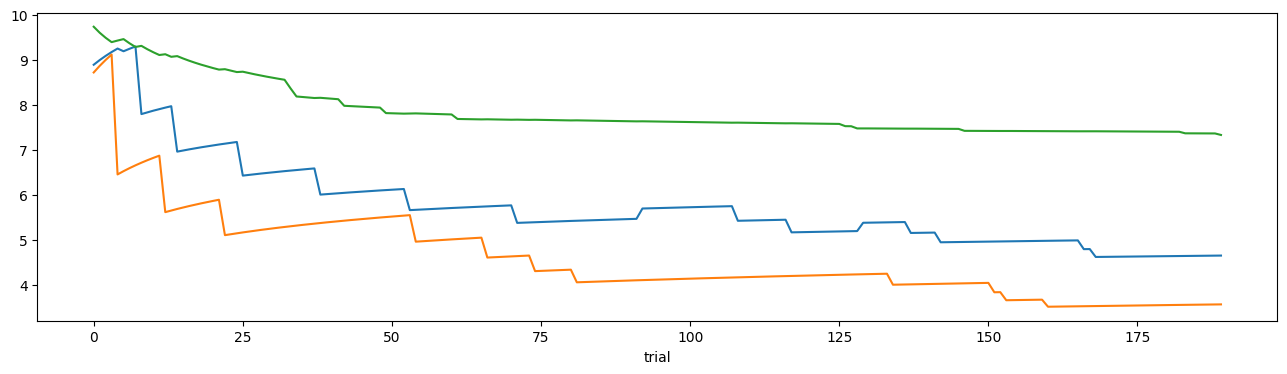

In [9]:
plt.figure(figsize=(16, 4))
s = 0
print(ucb_agent.lr[s], ucb_agent.c[s], ucb_agent.beta[s])
logits = prior_predictive_sample["logits"][0][1:, :, s, :].reshape(-1, num_arms)

if backend == "pyro":
    plt.plot(logits.cpu())
else:
    plt.plot(logits)

plt.xlabel("trial")

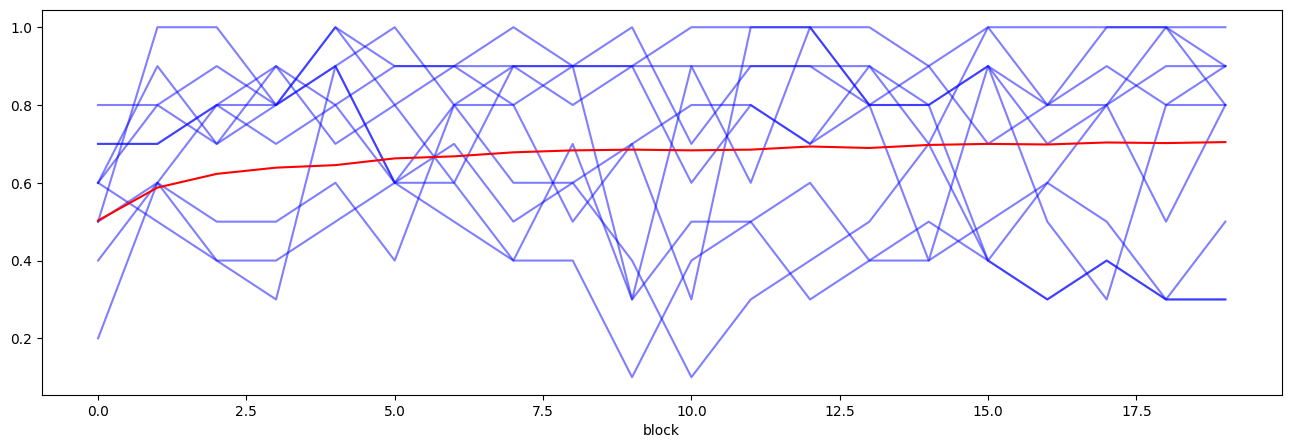

In [11]:
plt.figure(figsize=(16, 5))
if backend == "pyro":
    responses = np.array(prior_predictive_sample["responses"][0].cpu())
else:
    responses = np.array(prior_predictive_sample["responses"][0])

perc_correct = (responses == probs.argmax(-1)).mean(1)
plt.plot(perc_correct[:, :10], "b", alpha=0.5)
plt.plot(perc_correct.mean(-1), "r")
plt.xlabel("block");

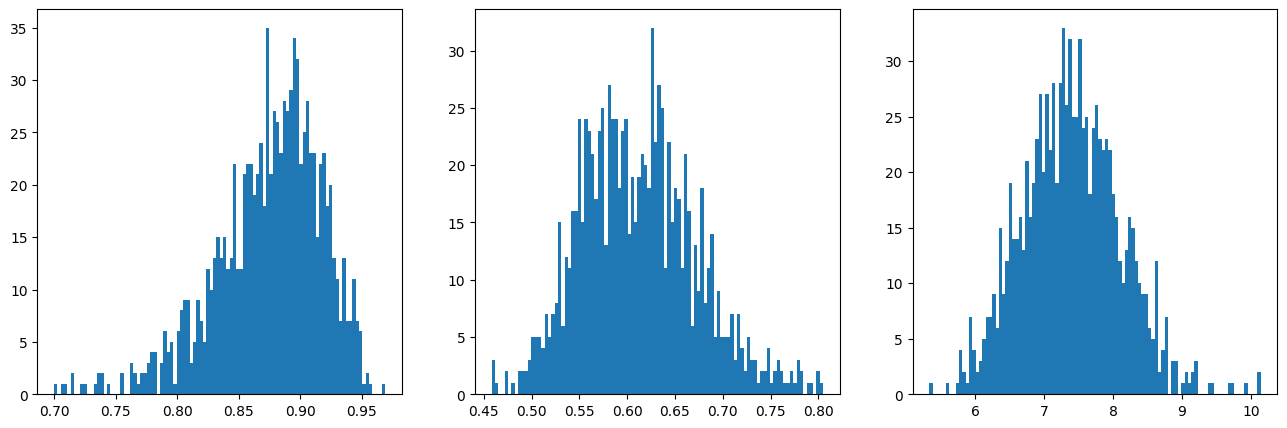

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
for i in range(3):
    axes[i].hist(true_vals[i], bins=100)

In [14]:
num_samples = 1000

# perform inference using stochastic variational inference
opts_svi = default_dict_svi
opts_svi.update({"sample_kwargs": {"num_samples": num_samples}, "iter_steps": 2_000})

samples, svi, results = run_svi(gen_model, posterior, measurments, opts=opts_svi)

Mean ELBO 145355.86: 100%|██████████| 2000/2000 [06:50<00:00,  4.87it/s]


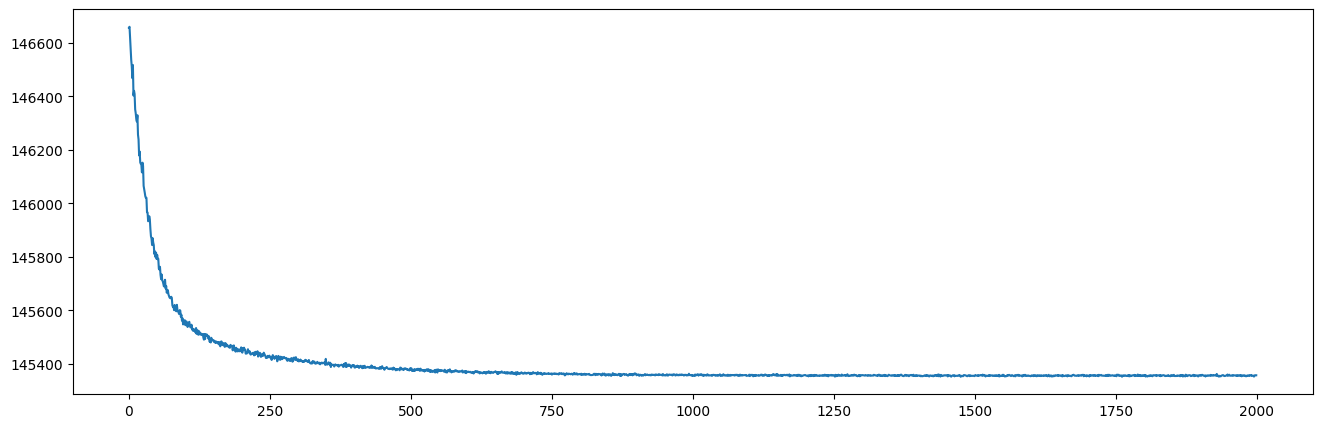

In [15]:
plt.figure(figsize=(16, 5))
plt.plot(results["loss"]) if backend == "pyro" else plt.plot(results.losses);

In [16]:
agents_ucb = transform_ucb(samples["z"], **opts_transform)
if backend == "pyro":
    svi_samples = (agents_ucb.lr.cpu(), agents_ucb.c.cpu(), agents_ucb.beta.cpu())
else:
    svi_samples = (agents_ucb.lr, agents_ucb.c, agents_ucb.beta)

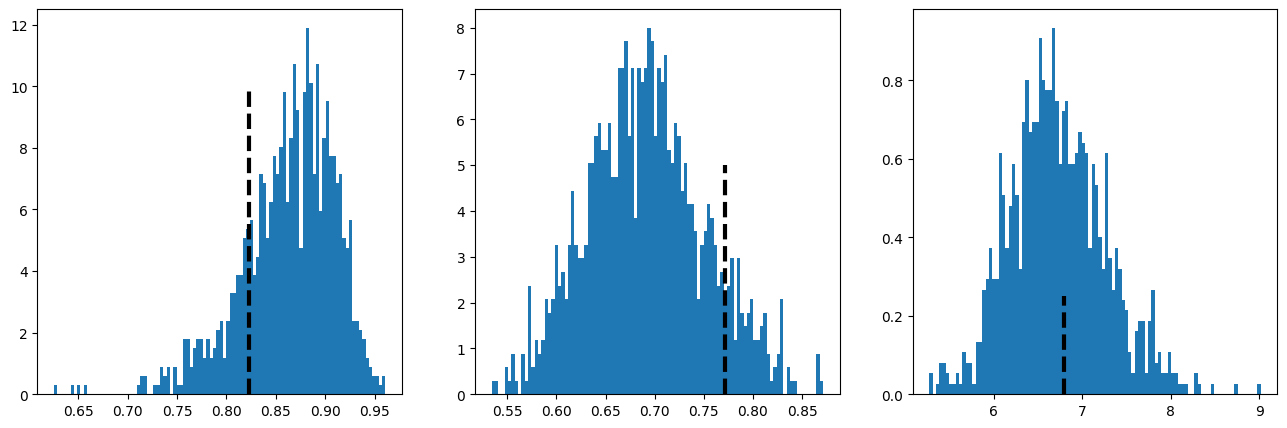

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

subject = 0
limit = [10, 5, 0.25]
for i in range(3):
    axes[i].hist(svi_samples[i][..., subject], bins=100, density=True)
    axes[i].vlines(true_vals[i][subject], 0, limit[i], "k", linestyle="--", lw=3)

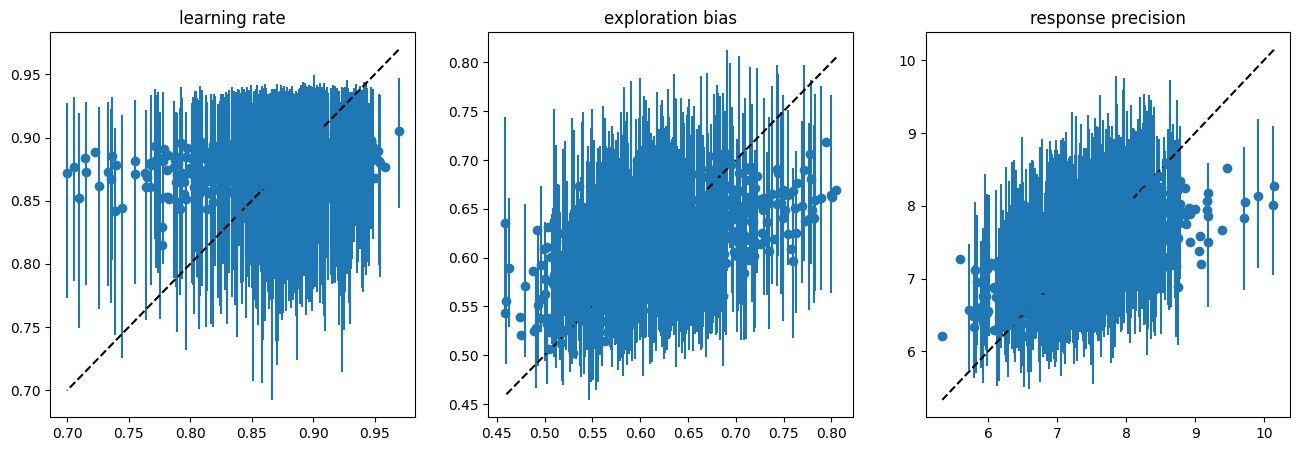

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for i in range(3):
    perc = np.percentile(svi_samples[i], [50, 5, 95], axis=0)
    yerr = np.abs(perc[1:] - perc[0])
    axes[i].errorbar(
        true_vals[i],
        perc[0],
        yerr=yerr,
        marker="o",
        errorevery=2,
        linestyle="",
    )
    v_range = (true_vals[i].max(), true_vals[i].min())
    axes[i].plot(v_range, v_range, "k--")

axes[0].set_title("learning rate")
axes[1].set_title("exploration bias")
axes[2].set_title("response precision");

In [ ]:
# it will take a lot of time to run this with pyro backend -- try numpyro instead

# assert False
num_samples = 1000
num_warmup = 1000

# perform inference using no-U-turn sampling
opts_nuts = default_dict_nuts
opts_nuts.update({"num_samples": num_samples, "num_warmup": num_warmup})

samples_nuts, mcmc = run_nuts(gen_model, measurments, opts=opts_nuts)

In [ ]:
agents_ucb = transform_ucb(samples_nuts["z"], **opts_transform)
if backend == "pyro":
    nuts_samples = (agents_ucb.lr.cpu(), agents_ucb.c.cpu(), agents_ucb.beta.cpu())
else:
    nuts_samples = (agents_ucb.lr, agents_ucb.c, agents_ucb.beta)

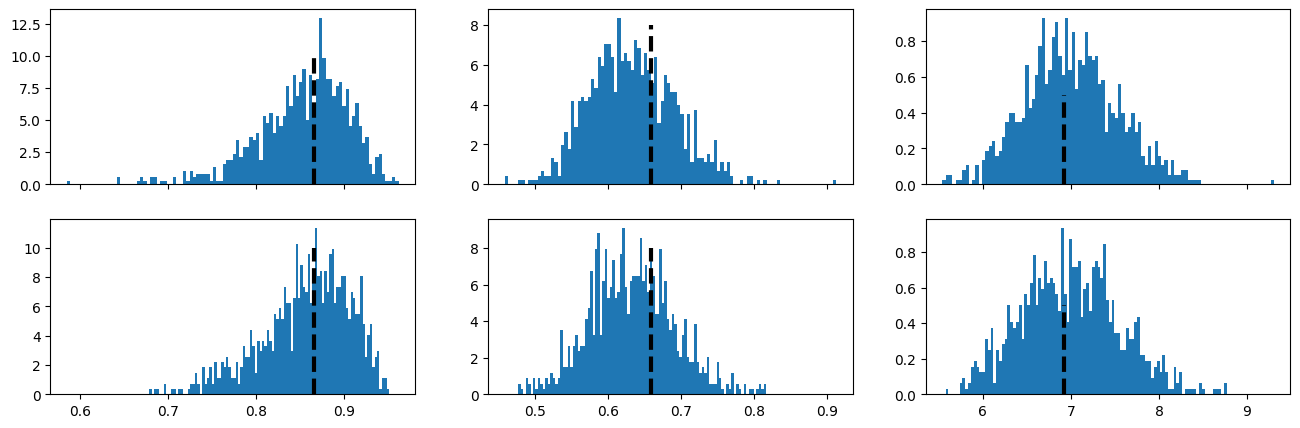

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(16, 5), sharex="col")

subject = 0
limit = [10, 8, 0.5]
for i in range(3):
    axes[0, i].hist(svi_samples[i][..., subject], bins=100, density=True)
    axes[0, i].vlines(true_vals[i][subject], 0, limit[i], "k", linestyle="--", lw=3)

    axes[1, i].hist(nuts_samples[i][..., subject], bins=100, density=True)
    axes[1, i].vlines(true_vals[i][subject], 0, limit[i], "k", linestyle="--", lw=3)

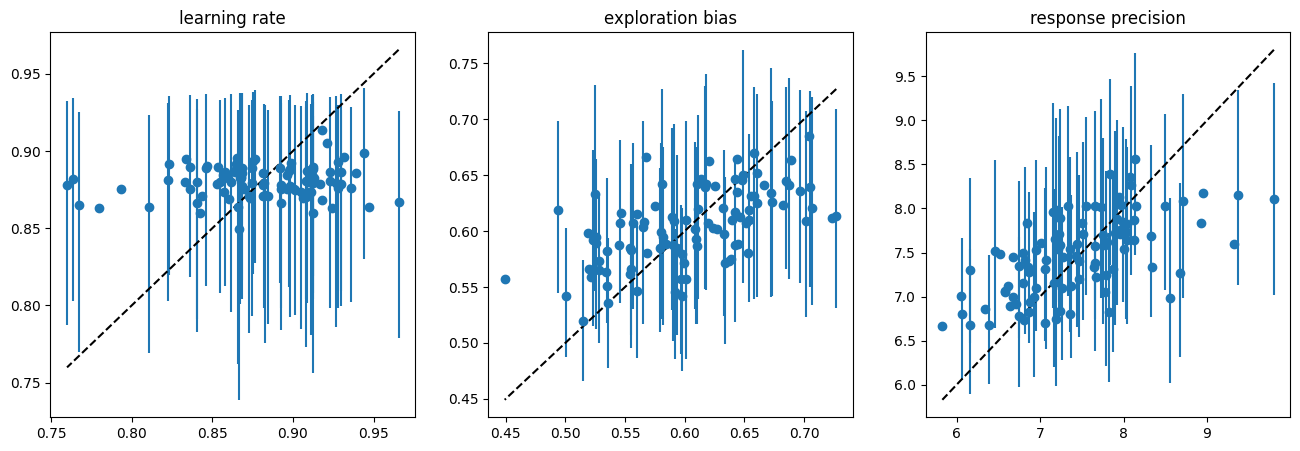

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for i in range(3):
    perc = np.percentile(nuts_samples[i], [50, 5, 95], axis=0)
    yerr = np.abs(perc[1:] - perc[0])
    axes[i].errorbar(
        true_vals[i],
        perc[0],
        yerr=yerr,
        marker="o",
        errorevery=2,
        linestyle="",
    )
    v_range = (true_vals[i].max(), true_vals[i].min())
    axes[i].plot(v_range, v_range, "k--")

axes[0].set_title("learning rate")
axes[1].set_title("exploration bias")
axes[2].set_title("response precision");